[![Open In Colab](./images/colab-badge.png)](https://colab.research.google.com/github/abrsvn/pyactr-book/blob/master/notebooks/30_power_law_model_of_forgetting.ipynb)

The code so far:

In [1]:
# loading the data
import pandas as pd

url = 'https://github.com/abrsvn/pyactr-book/blob/master/data/ebbinghaus_retention_data.csv?raw=true'
ebbinghaus_data = pd.read_csv(url)
ebbinghaus_data

,delay_in_hours,percent_savings
0,0.33,58.2
1,1.00,44.2
2,8.80,35.8
3,24.00,33.7
4,48.00,27.8
5,144.00,25.4
6,744.00,21.1


In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import numpy as np

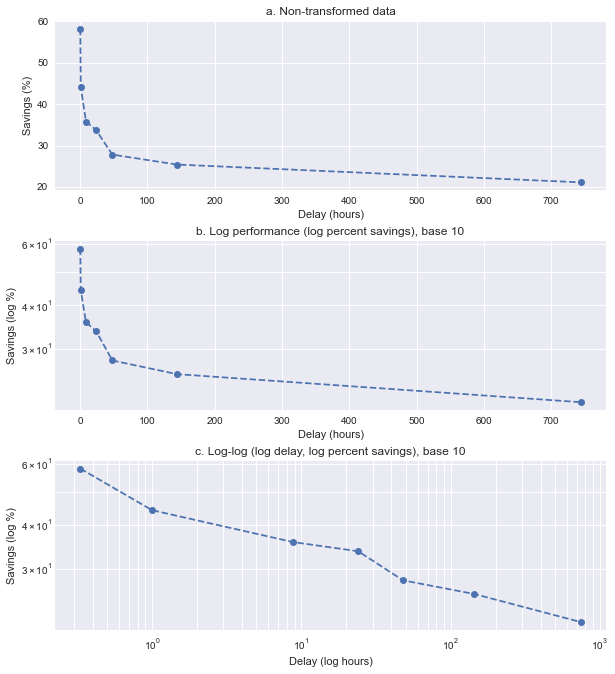

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3)
fig.set_size_inches(8.5, 9.3)

# plot 1
ax1.plot(ebbinghaus_data['delay_in_hours'],
         ebbinghaus_data['percent_savings'],
         marker='o', linestyle='--')
ax1.set_title('a. Non-transformed data')
ax1.set_xlabel('Delay (hours)')
ax1.set_ylabel('Savings (%)')

# plot 2
ax2.plot(ebbinghaus_data['delay_in_hours'],
        ebbinghaus_data['percent_savings'],
        marker='o', linestyle='--')
ax2.set_title('b. Log performance (log percent savings), base 10')
ax2.set_xlabel('Delay (hours)')
ax2.set_ylabel('Savings (log %)')
ax2.set_yscale('log', base=10)
ax2.grid(b=True, which='minor', color='w', linewidth=1.0)

# plot 3
ax3.plot(ebbinghaus_data['delay_in_hours'],
        ebbinghaus_data['percent_savings'],
        marker='o', linestyle='--')
ax3.set_title('c. Log-log (log delay, log percent savings), base 10')
ax3.set_xlabel('Delay (log hours)')
ax3.set_xscale('log', base=10)
ax3.set_ylabel('Savings (log %)')
ax3.set_yscale('log', base=10)
ax3.grid(b=True, which='minor', color='w', linewidth=1.0)
# clean up
plt.tight_layout(pad=0.5, w_pad=0.2, h_pad=0.7)

In [4]:
import pymc3 as pm

delay = ebbinghaus_data['delay_in_hours']
savings = ebbinghaus_data['percent_savings']

In [5]:
exponential_model = pm.Model()

with exponential_model:
    # priors
    intercept = pm.Normal('intercept', mu=0, sd=100)
    slope = pm.Normal('slope', mu=0, sd=100)
    sigma = pm.HalfNormal('sigma', sd=100)
    # likelihood
    mu = pm.Deterministic('mu', intercept + slope*delay)
    log_savings = pm.Normal('log_savings', mu=mu, sd=sigma,
                            observed=np.log(savings))

with exponential_model:
    trace = pm.sample(draws=5000, tune=50000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, intercept]


Sampling 4 chains for 50_000 tune and 5_000 draw iterations (200_000 + 20_000 draws total) took 39 seconds.
There were 1309 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.14668254265565023, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6997128393319356, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6498384452316661, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [6]:
mu = trace["mu"]

In [7]:
import arviz as az

/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


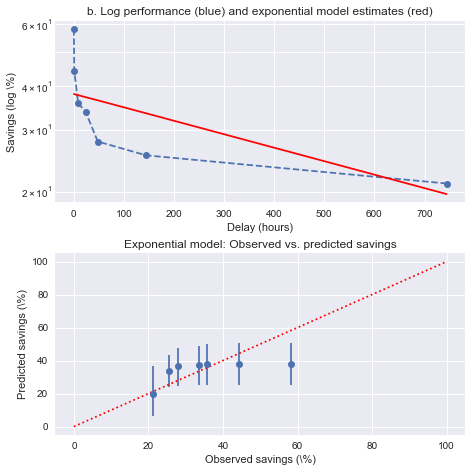

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)
fig.set_size_inches(6.5, 6.5)

# plot 1
ax1.plot(delay, savings, marker='o', linestyle='--')
ax1.plot(delay, np.median(np.exp(mu), axis=0), color='red', linestyle='-')
ax1.set_title('b. Log performance (blue) and exponential model estimates (red)')
ax1.set_xlabel('Delay (hours)')
ax1.set_ylabel('Savings (log \\%)')
ax1.set_yscale('log', base=10)
ax1.grid(b=True, which='minor', color='w', linewidth=1.0)

# plot 2
yerr=[np.median(np.exp(mu), axis=0)-az.hdi(np.exp(mu))[:,0],
      az.hdi(np.exp(mu))[:,1]-np.median(np.exp(mu), axis=0)]
ax2.errorbar(savings, np.median(np.exp(mu), axis=0), yerr=yerr,
             marker='o', linestyle='')
ax2.plot(np.linspace(0, 100, 10), np.linspace(0, 100, 10),\
         color='red', linestyle=':')
ax2.set_title('Exponential model: Observed vs. predicted savings')
ax2.set_xlabel('Observed savings (\\%)')
ax2.set_ylabel('Predicted savings (\\%)')
ax2.grid(b=True, which='minor', color='w', linewidth=1.0)

# clean up and save
plt.tight_layout(pad=0.5, w_pad=0.2, h_pad=0.7)

## The power-law model of forgetting

Instead, plot (c) in our first Ebbinghaus-data figure shows that performance is a _power function_ of time. That is, performance is a linear function of time only if *both performance and time are log-transformed*.

 __The power law of forgetting__:
- log scale: $\log(P) = \log(\alpha) - \beta \log(T)$
- $\boxed{P = \alpha T^{-\beta}}$ (final form of the forgetting function, obtained by exponentiating both sides of the log formula above)

A line fits the log-log (log savings-log delay) data very well

We can set up a Bayesian model that directly implements the formula above, and then examine its predictions. 

The code for the power law model is provided below, as well as the code for the plots.

In [9]:
power_law_model = pm.Model()

with power_law_model:
    # priors
    intercept = pm.Normal('intercept', mu=0, sd=100)
    slope = pm.Normal('slope', mu=0, sd=100)
    sigma = pm.HalfNormal('sigma', sd=100)
    # likelihood
    mu = pm.Deterministic('mu', intercept + slope*np.log(delay))
    log_savings = pm.Normal('log_savings', mu=mu, sd=sigma,
                            observed=np.log(savings))

with power_law_model:
    trace = pm.sample(draws=5000, tune=50000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, intercept]


Sampling 4 chains for 50_000 tune and 5_000 draw iterations (200_000 + 20_000 draws total) took 43 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9365535082754206, but should be close to 0.8. Try to increase the number of tuning steps.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6010565542843095, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


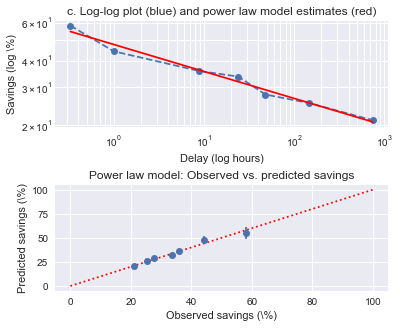

In [10]:
mu = trace["mu"]

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)
fig.set_size_inches(5.5, 4.5)

# plot 1
ax1.plot(delay, savings, marker='o', linestyle='--')
ax1.plot(delay, np.median(np.exp(mu), axis=0), color='red', linestyle='-')
ax1.set_title('c. Log-log plot (blue) and power law model estimates (red)')
ax1.set_xlabel('Delay (log hours)')
ax1.set_xscale('log', base=10)
ax1.set_ylabel('Savings (log \\%)')
ax1.set_yscale('log', base=10)
ax1.grid(b=True, which='minor', color='w', linewidth=1.0)

# plot 2
yerr=[np.median(np.exp(mu), axis=0)-az.hdi(np.exp(mu))[:,0],\
      az.hdi(np.exp(mu))[:,1]-np.median(np.exp(mu), axis=0)]
ax2.errorbar(savings, np.median(np.exp(mu), axis=0), yerr=yerr,\
             marker='o', linestyle='')
ax2.plot(np.linspace(0, 100, 10), np.linspace(0, 100, 10),\
         color='red', linestyle=':')
ax2.set_title('Power law model: Observed vs. predicted savings')
ax2.set_xlabel('Observed savings (\\%)')
ax2.set_ylabel('Predicted savings (\\%)')
ax2.grid(b=True, which='minor', color='w', linewidth=1.0)

# clean up and save
plt.tight_layout(pad=0.5, w_pad=0.2, h_pad=0.7)

The top plot in the figure above reproduces the log-log plot in the third panel of original Ebbinghaus-data figure, **together with the line of best fit predicted by the power law model of forgetting**.
- we see that the model predictions match the data very well

This is further confirmed by the second plot in the figure above:
- the points are almost perfectly aligned with the diagonal
- that is, the savings predicted by the power law model are very close to the observed savings
- furthermore, the confidence intervals around most predictions are so tight that we do not see any segments extending outward from the plotted points
- that is, the power law model makes correct predictions, and it is furthermore highly confident about the predictions it makes (with somewhat less confidence for higher savings)

We conclude that the best model for the Ebbinghaus forgetting data is a power law model, and not an exponential one.